# Brain tumor segmentation using U-Net

### PART 1- Set up environment

In [4]:
# scikit-image==0.20.0 scikit-learn==1.0.2 opencv-python==4.7.0.68 !pip install nibabel==5.1.0 matplotlib==3.5.1  tensorflow==2.8.4 keras==2.8.0 kaggle==1.5.13 pandas==1.4.2


In [6]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

### Part 2 - Dataset 

In [9]:
import os
import glob
import nibabel as nib
base_dir = "/Users/arjunpesaru/Desktop/opencv  u Net/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
nii_files = glob.glob(os.path.join(base_dir, "BraTS20_Training_*/BraTS20_Training_*_t1ce.nii"))

if not nii_files:
    raise FileNotFoundError("No .nii files found! Check the base directory.")
else:
    print(f"Found {len(nii_files)} .nii files.")
    file_path = nii_files[0]  
    print(f"Using file: {file_path}")
data = nib.load(file_path).get_fdata()
print(f"Data shape: {data.shape}")

for file_path in nii_files:
    print(f"Processing: {file_path}")
    data = nib.load(file_path).get_fdata()


Found 369 .nii files.
Using file: /Users/arjunpesaru/Desktop/opencv  u Net/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_082/BraTS20_Training_082_t1ce.nii
Data shape: (240, 240, 155)
Processing: /Users/arjunpesaru/Desktop/opencv  u Net/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_082/BraTS20_Training_082_t1ce.nii
Processing: /Users/arjunpesaru/Desktop/opencv  u Net/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_244/BraTS20_Training_244_t1ce.nii
Processing: /Users/arjunpesaru/Desktop/opencv  u Net/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_076/BraTS20_Training_076_t1ce.nii
Processing: /Users/arjunpesaru/Desktop/opencv  u Net/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_049/BraTS20_Trainin

In [14]:

old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

try: 
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("File renamed alredy")

File renamed alredy


### Part 3 - Data Exploration

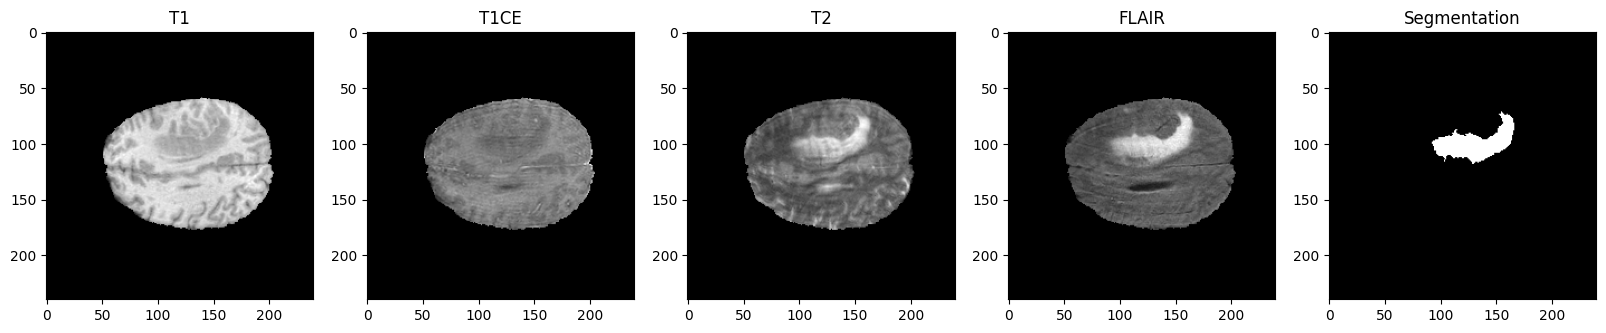

In [222]:

sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()

In [376]:
print(t1_data.shape)
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


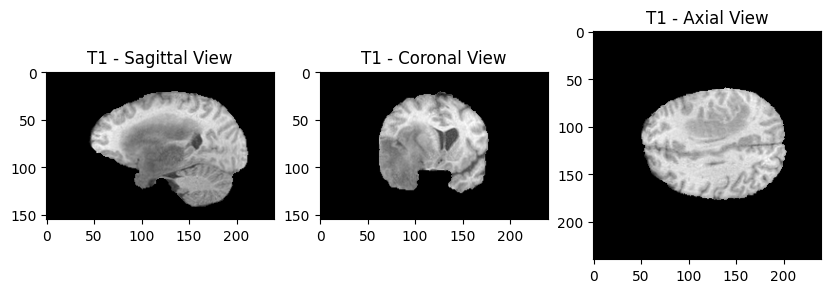

In [600]:

slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

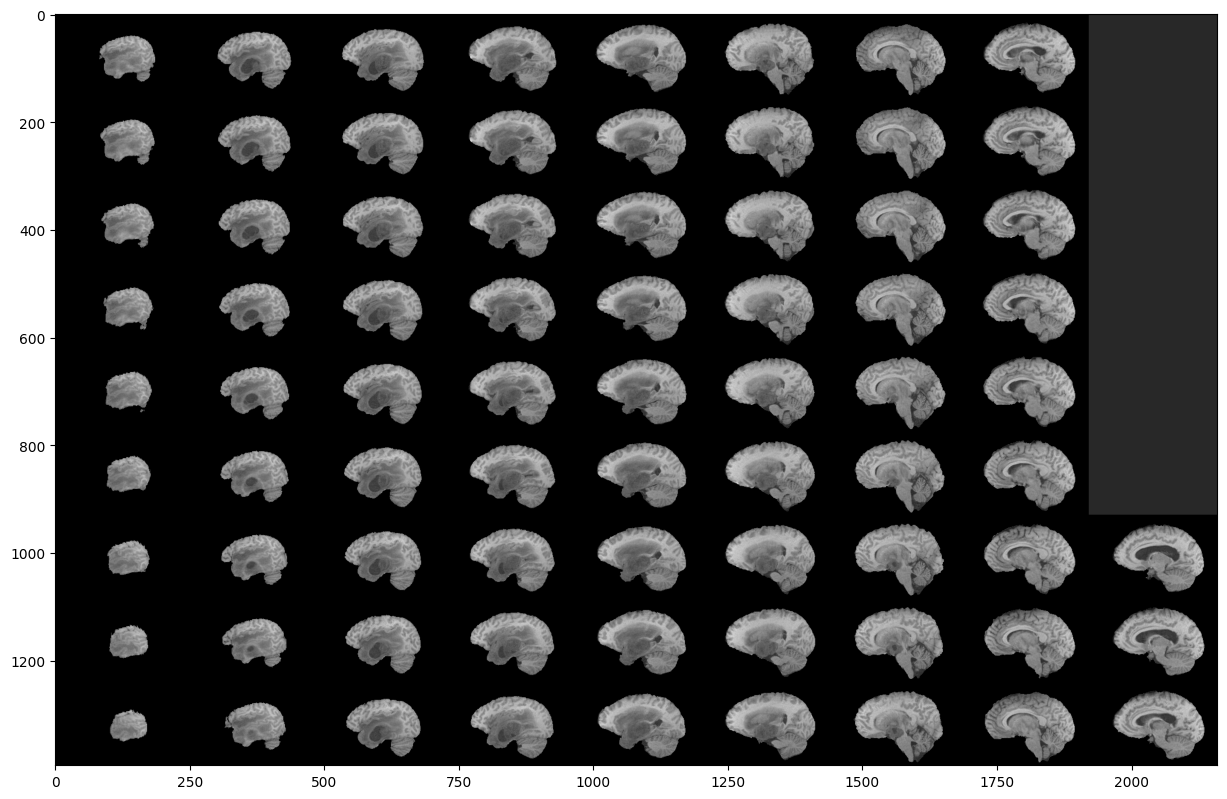

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

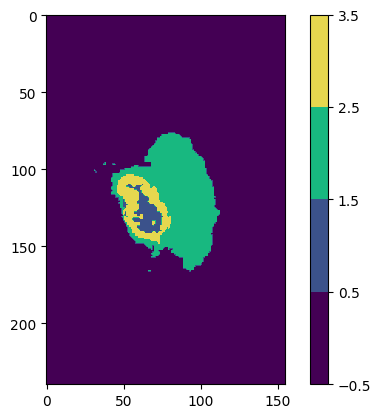

In [12]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [18]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


In [19]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


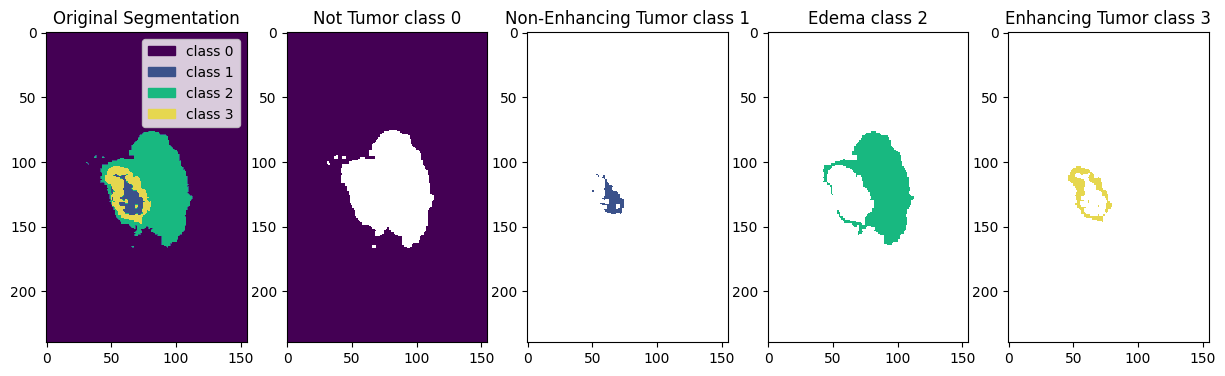

In [18]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

In [33]:

VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

### Part 4 - Prepare data for Training

In [8]:

data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [ ]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [10]:

samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


#### Part 4.1 DataGenerator



In [ ]:

IMG_SIZE = 128

class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim 
        self.batch_size = batch_size 
        self.list_IDs = list_IDs 
        self.n_channels = n_channels 
        self.shuffle = shuffle 
        self.on_epoch_end() 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'

        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):
            
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'

            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        return X/np.max(X), Y
        
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

### Part 5 - Define the model


In [20]:

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

In [21]:

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

#### Part 5.1 - Build the model

In [64]:

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

#### Part 5.1 - Set up callbacks

In [23]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
    
    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

### Part 6 - Train & Save the model

In [67]:
model.fit(training_generator,
          epochs=35,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/35
218/250 [=========================>....] - ETA: 11s - loss: 0.1447 - accuracy: 0.9761 - mean_io_u_6: 0.5787 - dice_coef: 0.2617 - precision: 0.9754 - sensitivity: 0.9572 - specificity: 0.9936
Epoch 1: val_loss improved from inf to 0.09995, saving model to model_.01-0.099951.m5
250/250 [==============================] - 119s 469ms/step - loss: 0.1374 - accuracy: 0.9765 - mean_io_u_6: 0.5826 - dice_coef: 0.2638 - precision: 0.9760 - sensitivity: 0.9598 - specificity: 0.9936 - val_loss: 0.1000 - val_accuracy: 0.9790 - val_mean_io_u_6: 0.3759 - val_dice_coef: 0.2779 - val_precision: 0.9784 - val_sensitivity: 0.9784 - val_specificity: 0.9929 - lr: 0.0010
Epoch 2/35
250/250 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9808 - mean_io_u_6: 0.6350 - dice_coef: 0.2787 - precision: 0.9811 - sensitivity: 0.9788 - specificity: 0.9937
Epoch 2: val_loss improved from 0.09995 to 0.08250, saving model to model_.02-0.082503.m5
250/250 [==============================

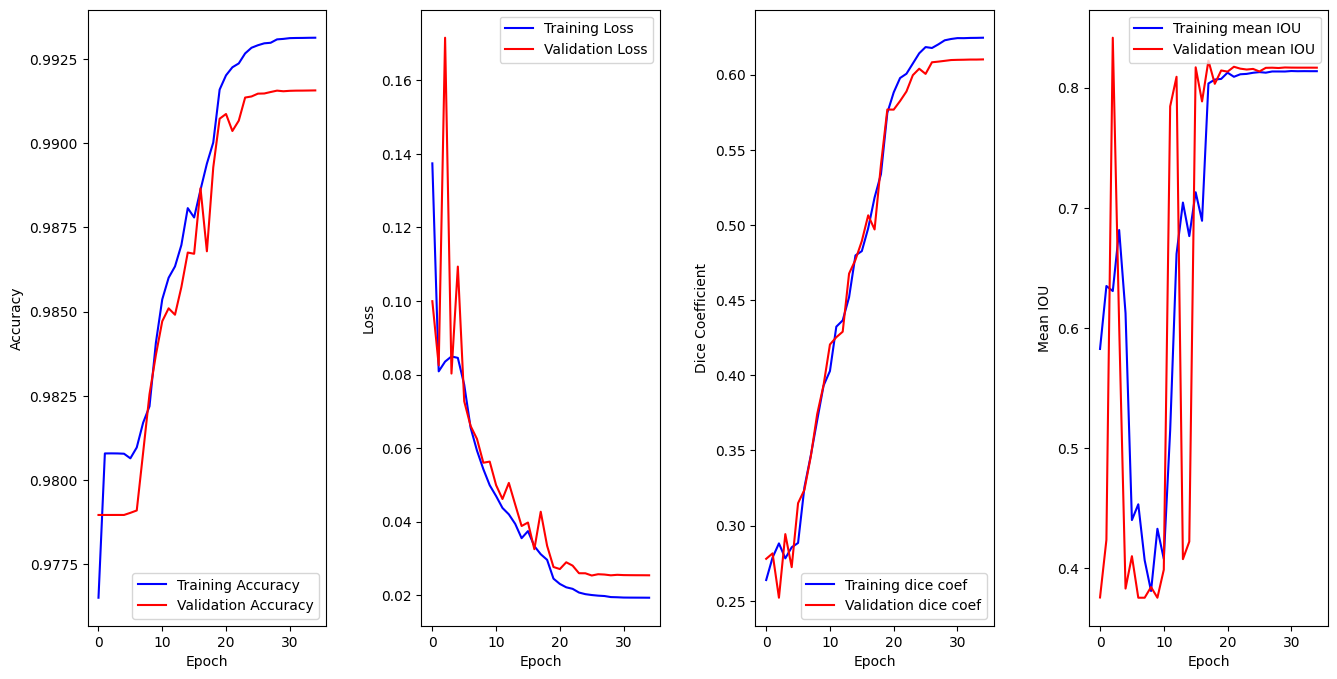

In [84]:

history = pd.read_csv('training.log', sep=',', engine='python')

fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
axs[3].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()

plt.subplots_adjust(wspace=0.4)

plt.show()

### Part 7 - Predict tumor segmentations

In [ ]:
# Compile a model and load our saved weights
# IMG_SIZE = 128
# input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

# best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

# best_saved_model.load_weights('model_.26-0.025329.m5')

In [210]:
def predict_segmentation(sample_path):
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [339]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    random_sample = random.choice(samples_list)

    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    predicted_seg = predict_segmentation(random_sample_path)

    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    all = predicted_seg[slice_to_plot,:,:,1:4] 
    zero = predicted_seg[slice_to_plot,:,:,0] 
    first = predicted_seg[slice_to_plot,:,:,1] 
    second = predicted_seg[slice_to_plot,:,:,2] 
    third = predicted_seg[slice_to_plot,:,:,3] 

    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')
    
    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')
    
    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')
    
    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')
    
    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

#### Plot Random predictions & Compare with Original (Ground truth) 

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_266


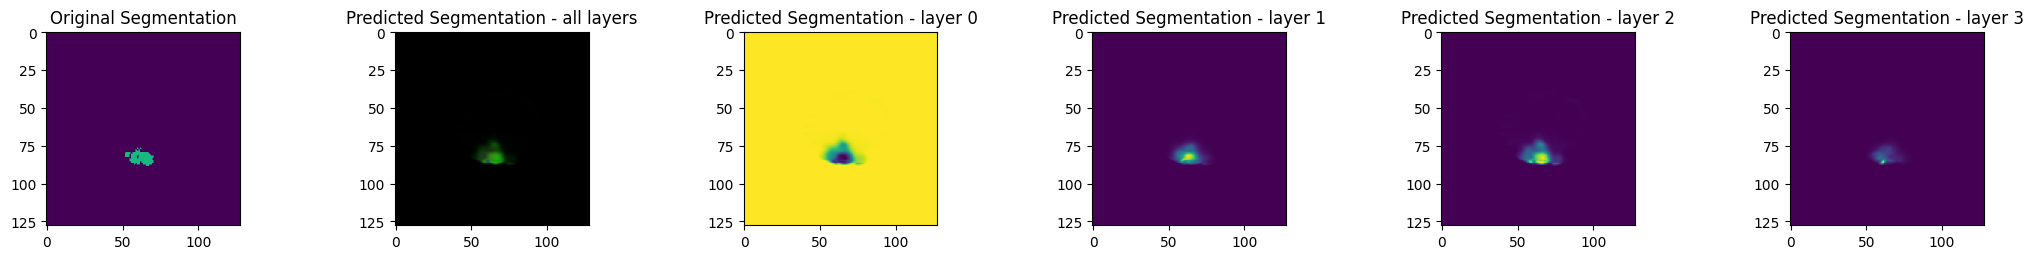

In [47]:
show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_274


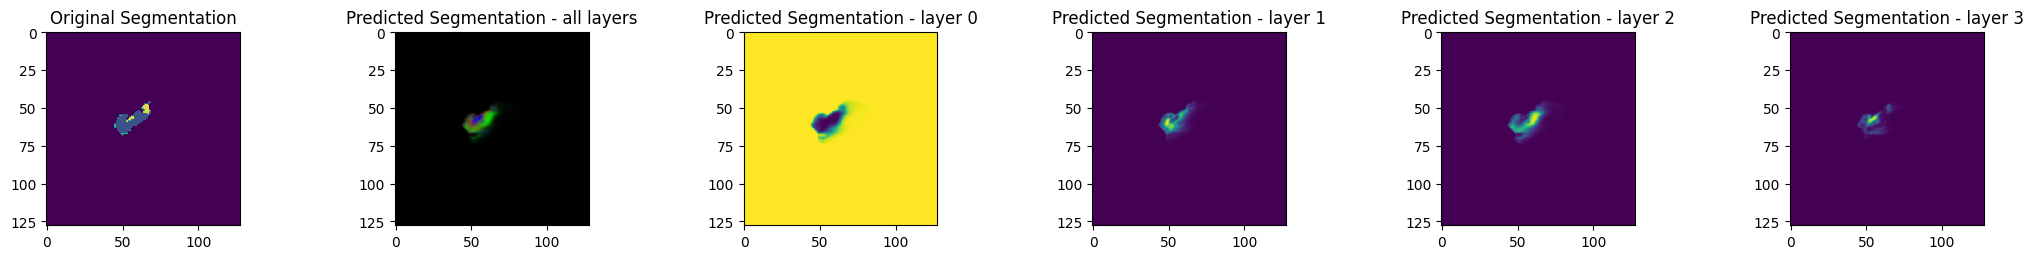

In [51]:
show_predicted_segmentations(samples_test, 70, cmap, norm)

#### Part 8- Post-processing

In [40]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):
    

    sample_path = os.path.join(data_path, sample, sample)
    
    predicted_seg = predict_segmentation(sample_path)
   

    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    

    seg[seg==4] = 3

    seg[seg==0] = np.nan
    
    
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]


    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    all = predicted_seg[slice_to_plot,:,:,1:4] 
    
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')
    
    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

    plt.subplots_adjust(wspace=0.8)
    
    plt.show()

3/3 [==============================] - 0s 19ms/step
Patient number:  BraTS20_Training_051


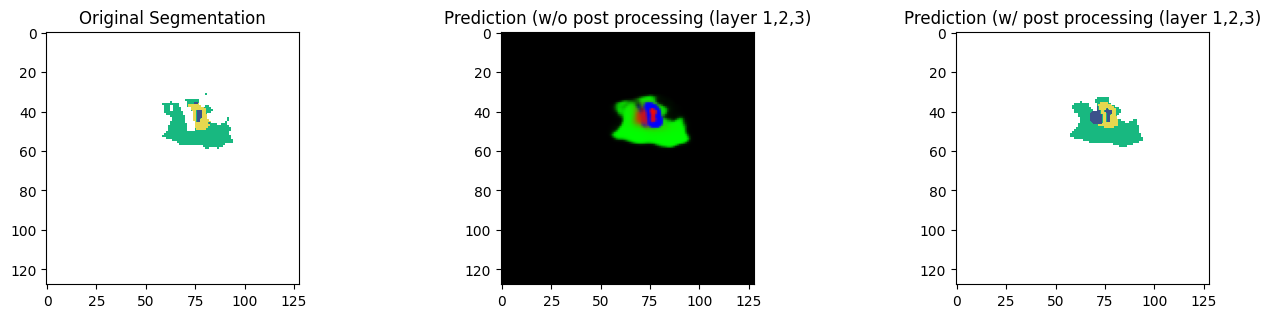

In [42]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 20ms/step
Patient number:  BraTS20_Training_051


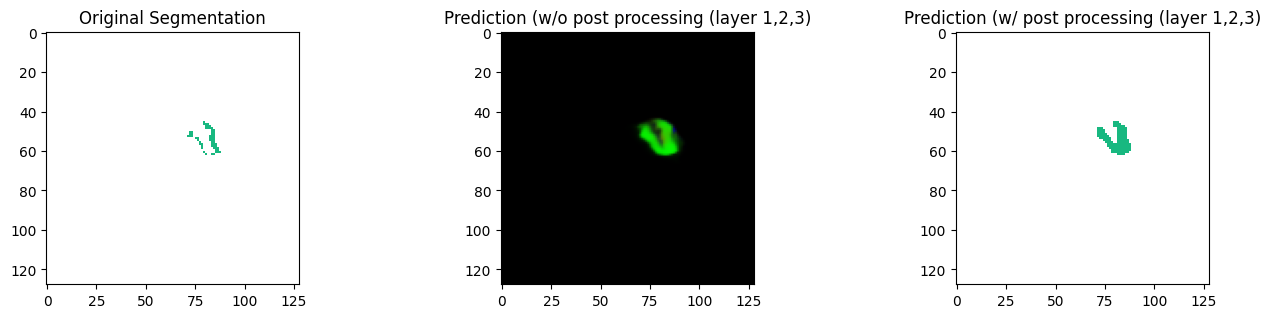

In [44]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

### Step 8 - Evaluate the model

In [268]:


results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 [==============================] - 12s 260ms/step - loss: 0.0206 - accuracy: 0.9935 - mean_io_u_6: 0.8176 - dice_coef: 0.6008 - precision: 0.9938 - sensitivity: 0.9922 - specificity: 0.9979

Model evaluation on the test set:
Loss : 0.0206
Accuracy : 0.9935
MeanIOU : 0.8176
Dice coefficient : 0.6008
Precision : 0.9938
Sensitivity : 0.9922
Specificity : 0.9979
